<a href="https://colab.research.google.com/github/schwallergroup/ai4chem_course/blob/main/notebooks/03%20-%20Intro%20to%20Deep%20Learning/02_graph_nns.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Week 3 tutorial 2 - AI 4 Chemistry

## Table of content

0. Relevant packages
1. Inductive biases
2. Graph neural network in chemistry

# 0. Relevant packages

### Pytorch Geometric (PyG)
PyG is a library built upon PyTorch to easily write and train Graph Neural Networks (GNNs) for a wide range of applications related to structured data. You can also browse its [documentation](https://pytorch-geometric.readthedocs.io/en/latest/) for additional details.

In [1]:
# Install all libraries
# CoLab has already preinstalled Pytorch for you
! pip install pytorch-lightning wandb rdkit ogb deepchem
# install PyG
import torch
VERSION = torch.__version__
! pip install pyg_lib torch_scatter torch_sparse -f https://data.pyg.org/whl/torch-{VERSION}.html
! pip install torch-geometric

Looking in links: https://data.pyg.org/whl/torch-2.1.0+cu121.html


Set a random seed to ensure repeatability of experiments

In [2]:
import random
import numpy as np
import torch

# Random Seeds and Reproducibility
torch.manual_seed(0)
torch.cuda.manual_seed(0)
np.random.seed(0)
random.seed(0)

---

One of the promises of deep learning algorithms is that they can learn to `automatically extract features from the raw data`.\
**However, so far we have used the same featurization methods as we used for the more basic models.**

> Can our models directly take a molecule as input?

# 1. Inductive biases

**Inductive biases** are assumptions we make about the data, that help our models extract signal from it. These assumptions are encoded in the model's architecture.

For instance, when we (humans) look at images, we think differently than when we read a book, or than when we analyze a molecule. **Processing all these different types of data requires different ways of interpretation, and thus different assumptions about the data**.

When building models, we attempt to encode these inductive biases in our model's architecture so they know how to read and process the data.

A natural way of representing molecules is as graphs. A graph is a collection of nodes (atoms) and edges (bonds).

<div align="center">
<img src="https://github.com/schwallergroup/ai4chem_course/blob/main/notebooks/03%20-%20Intro%20to%20Deep%20Learning/img/Chloroquine-2D-molecular-graph.png?raw=1" width="500"/>
</div>

In the end, this is what we assume from the data:

> Molecules are formed by atoms connected by bonds, and each atom is influenced mostly by its closest neighbors.\
> Molecular properties are determined solely by the molecular graph.

This is what **we assume** and thus what **we tell our model**. The specific details of how to calculate the solubility of a molecule (or any other property), that's exactly what the model will try to learn from the data!

# 2. Graph neural network in chemistry

## 2.1 Graph representation

In [graph theory](https://en.wikipedia.org/wiki/Graph_theory), a graph $G=(V,E)$ is defined by a set of **nodes** (also called **vertices**) $V$ and a set of **edges** (also called **links**) $E$ between these vertices. More specifically:

- $V = \{ v_1, \: ..., \: v_n \}$, a set of nodes;
- $E \subseteq \{ (i,j) \: | \: i,j \in V,  \: i \neq j \}$, a set of edges representing connections between nodes.

If the edges of a graph have directions, the graph is called a directed graph, otherwise it is called an undirected graph.

<center width="100%" style="padding:10px"><img src="https://github.com/schwallergroup/ai4chem_course/blob/main/notebooks/03%20-%20Intro%20to%20Deep%20Learning/img/graphs.png?raw=1" width="250px"></center>

In many cases we also have attribute or feature information associated with a graph:
- node features: $\mathbf{X} = [..., \: x_i, \: ...]^T \in \mathbb{R}^{|V| \times m}$, and $x_i \in \mathbb{R}^m$ denotes the feature of node $i$;
- edge features: $\mathbf{L} = [..., \: l_{i,j}, \: ...]^T \in \mathbb{R}^{|E| \times r}$, and $l_{i,j} \in \mathbb{R}^r$ denotes the feature of the edge between node $i$ and node $j$;
- graph features: $\mathbf{G} = (..., \: g_i, \: ...) \in \mathbb{R}^s$, and $g_i$ is the feature (or label) $i$ of the graph, which is usually the prediction target.

For instance, let's look at the following undirected graph with node features:

<center width="100%" style="padding:10px"><img src="https://github.com/schwallergroup/ai4chem_course/blob/main/notebooks/03%20-%20Intro%20to%20Deep%20Learning/img/graph_example.svg?raw=1" width="250px"></center>

This graph has 4 nodes and 4 edges. The nodes are $V=\{1,2,3,4\}$, and edges $E=\{(1,2), (2,3), (2,4), (3,4)\}$. Note that for simplicity, we don't add mirrored pairs like $(2,1)$. And we have the following node features:

$$
\mathbf{X} = \begin{bmatrix}
    0 & 1 & 2\\
    1 & 0 & 1\\
    1 & 1 & 0\\
    3 & 1 & 4
\end{bmatrix}
$$

The **adjacency matrix** $A$ is a square matrix whose elements indicate whether pairs of nodes are adjacent, i.e. connected, or not. In the simplest case, $A_{ij}$ is 1 if there is a connection from node $i$ to $j$, and otherwise 0. For an undirected graph, keep in mind that $A$ is a symmetric matrix ($A_{ij}=A_{ji}$). For the example graph above, we have the following adjacency matrix:

$$
A = \begin{bmatrix}
    0 & 1 & 0 & 0\\
    1 & 0 & 1 & 1\\
    0 & 1 & 0 & 1\\
    0 & 1 & 1 & 0
\end{bmatrix}
$$

### Molecular graph
A [molecular graph](https://en.wikipedia.org/wiki/Molecular_graph) is a labeled graph whose nodes correspond to the atoms of the compound and edges correspond to chemical bonds. It also has node features (**atom features**), edge features (**bond features**) and graph labels (chemical properties of a molecule). Next, we demonstrate a simple example of building a molecular graph (undirected). In this example, we do not consider hydrogen atoms as nodes.

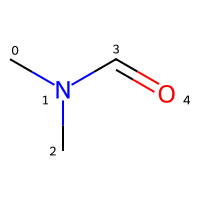

In [3]:
from rdkit.Chem import MolFromSmiles
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw

IPythonConsole.ipython_useSVG = True  # < use SVGs instead of PNGs
IPythonConsole.drawOptions.addAtomIndices = True  # adding indices for atoms
IPythonConsole.drawOptions.addBondIndices = False  # not adding indices for bonds
IPythonConsole.molSize = 200, 200

# N,N-dimethylformamide (DMF)
dmf_smiles = 'CN(C)C=O'
mol = MolFromSmiles(dmf_smiles)
# show molecular graph of DMF, atom indices = node indices
mol

### Atom features

| feature | description |
| ---- | ----  |
| atom type  | atomic number |
| degree  | number of directly-bonded neighbor atoms, including H atoms |
| formal charge | integer electronic charge assigned to atom |
| hybridization | sp, sp2, sp3, sp3d, or sp3d2 |

In [4]:
ATOM_FEATURES = {
    'atom_type' : [1, 6, 7, 8, 9],  # elements: H, C, N, O, F
    'degree' : [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 'misc'],
    'formal_charge' : [-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 'misc'],
    'hybridization' : [
        'SP', 'SP2', 'SP3', 'SP3D', 'SP3D2', 'misc'
        ],
}

def get_atom_fv(atom):
    """
    Converts rdkit atom object to feature list of indices
    :param atom: rdkit atom object
    :return: list
    """
    atom_fv = [
        ATOM_FEATURES['atom_type'].index(atom.GetAtomicNum()),
        ATOM_FEATURES['degree'].index(atom.GetTotalDegree()),
        ATOM_FEATURES['formal_charge'].index(atom.GetFormalCharge()),
        ATOM_FEATURES['hybridization'].index(str(atom.GetHybridization())),
    ]
    return atom_fv

atom_fvs = [get_atom_fv(atom) for atom in mol.GetAtoms()]
atom_fvs

[[1, 4, 5, 2], [2, 3, 5, 1], [1, 4, 5, 2], [1, 3, 5, 1], [3, 1, 5, 1]]

One chemical issue we need to pay attention to is that the N atom in DMF are `sp2` hybridized instead of `sp3`.

<div align="center">
<img src="https://github.com/schwallergroup/ai4chem_course/blob/main/notebooks/03%20-%20Intro%20to%20Deep%20Learning/img/DMF_N_sp2.png?raw=1" width="600"/>
</div>


### Bond features

| feature | description |
| ---- | ----  |
| bond type  | single, double, triple, or aromatic |
| stereo | none, any, E/Z or cis/trans |
| conjugated  | whether the bond is conjugated |

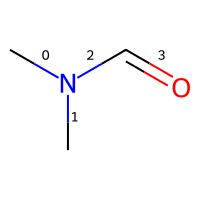

In [5]:
# Show indices of bonds
IPythonConsole.drawOptions.addAtomIndices = False  # not adding indices for atoms
IPythonConsole.drawOptions.addBondIndices = True  # adding indices for bonds
mol

In [6]:
BOND_FEATURES = {
    'bond_type' : [
        'SINGLE',
        'DOUBLE',
        'TRIPLE',
        'AROMATIC',
        'misc'
    ],
    'stereo': [
        'STEREONONE',
        'STEREOZ',
        'STEREOE',
        'STEREOCIS',
        'STEREOTRANS',
        'STEREOANY',
    ],
    'conjugated': [False, True],
}

def get_bond_fv(bond):
    """
    Converts rdkit bond object to feature list of indices
    :param bond: rdkit bond object
    :return: list
    """
    bond_fv = [
        BOND_FEATURES['bond_type'].index(str(bond.GetBondType())),
        BOND_FEATURES['stereo'].index(str(bond.GetStereo())),
        BOND_FEATURES['conjugated'].index(bond.GetIsConjugated()),
    ]
    return bond_fv

bond_fvs = [get_bond_fv(bond) for bond in mol.GetBonds()]
bond_fvs

[[0, 0, 0], [0, 0, 0], [0, 0, 1], [1, 0, 1]]

### Edge index
In many cases, a list of paired node indices are used to describe edges rather than adjacency matrix. Here we use paired node indices (`edge_index`) with shape (2, num_edges) to define the edges in a graph.

$$
\mathbf{E} = \begin{bmatrix}
    ..., & i, & ..., & j, & ... \\
    ..., & j, & ..., & i, & ...
\end{bmatrix}
$$
Like, there has an edge between node $i$ and node $j$ (undirected graph).


In [12]:
edge_index0, edge_index1 = [], []

for bond in mol.GetBonds():
    i, j = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
    edge_index0 += [i, j]
    edge_index1 += [j, i]

edge_index = [edge_index0, edge_index1]
edge_index

[[0, 1, 1, 2, 1, 3, 3, 4], [1, 0, 2, 1, 3, 1, 4, 3]]

### Molecular graph data

We set the density of DMF(0.944 $g/cm^3$) as the graph feature (label). Here we use [Data](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.data.Data.html#torch_geometric.data.Data) class in `PyG` to create a graph data for DMF.

In [13]:
import torch
from torch_geometric.data import Data

# convert our data to tensors, which are used for model training
x = torch.tensor(atom_fvs, dtype=torch.float)
edge_index = torch.tensor(edge_index, dtype=torch.long)
edge_attr = torch.tensor(bond_fvs, dtype=torch.float)
y = torch.tensor([0.944], dtype=torch.float)

dmf_data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)
dmf_data

Data(x=[5, 4], edge_index=[2, 8], edge_attr=[4, 3], y=[1])

## 2.2 Graph Neural Network

A [graph neural network (GNN)](https://en.wikipedia.org/wiki/Graph_neural_network) is a class of artificial neural networks for processing data that can be represented as graphs. GNNs rely on [message passing methods](https://arxiv.org/abs/1704.01212), which means that nodes exchange information with the neighbors, and send "messages" to each other. Generally, GNNs operate in two phases: a **message passing** phase, which transmits information across the molecule to build a neural representation of the molecule, and a **readout** phase, which uses the final representation of the molecule to make predictions about the properties of interest.

### Message passing

Before looking at the math, we can try to visually understand how message passing works. The first step is that each node creates a `feature vector` that represents the `message` it wants to send to all its neighbors. In the second step, the messages are sent to the neighbors, so that a node receives one message per adjacent node. As shown in the figure below, after a message passing step, `node 1` can get the message from `node 2`, and `node 2` can get messages from `node 1`, `node 3` and `node 4`. The third step is that each node will aggregate all messages from neighbors and get a `message vector`. Then, the fourth step is that each node updates its `feature vector` based on its `message vector` and previous `feature vector`.

<center width="100%" style="padding:10px"><img src="https://github.com/schwallergroup/ai4chem_course/blob/main/notebooks/03%20-%20Intro%20to%20Deep%20Learning/img/graph_message_passing.svg?raw=1" width="700px"></center>

Moreover, with the iteration of message passing, each node can obtain the feature vectors of more distant nodes and not limited to neighbors. As shown in the figure below, node `A` can get informations from node `E` and node `F` in the interation 2, which are not the neighbors of node `A`.  Node `C`, the neighbor of node `A`, can obtain the information of nodes `E` and `F` in the iteration 1, so node `A` can obtain the information of nodes `E` and `F` in the iteration 2.

<center width="100%" style="padding:10px"><img src="https://github.com/schwallergroup/ai4chem_course/blob/main/notebooks/03%20-%20Intro%20to%20Deep%20Learning/img/messages.svg?raw=1" width="700px"></center>

**You can also read the mathematical formulas to better understand the process of message passing.**

1) Initialization

Get initial hidden feature vector $h_i^0$ of node $i$ from its original node features $x_i$
$$
h_i^0 = I(x_i), \quad \forall i \in V
\tag{1}
$$
where $I$ is initialize function

2) Send message
$$
m_{j \rightarrow i}^{t+1} = M(h_i^t, \: h_j^t, \: e_{i,j})
\tag{2}
$$
where $m_{j \rightarrow i}^{t+1}$ is the message sent from node $j$ to $i$ at the $t+1$ iteration, $M$ is message function, and $e_{i,j}$ is the feature of edge between node $i$ and $j$

3) Message aggregation
$$
m_i^{t+1} = \sum_{j \in N(i)} m_{j \rightarrow i}^{t+1}
\tag{3}
$$
where $N(i)$ presents all neighbor nodes of node $i$, and $m_i^{t+1}$ is the aggregated message of node $i$ at the $t+1$ iteration

4) Node update
$$
h_i^{t+1} = U(h_i^t, \: m_i^{t+1})
\tag{4}
$$
where $h_i^t$ is the hidden feature vector of node $i$ at the $t$ iteration, and $U$ is the update function

### Readout
The readout layers will aggregate the hidden feature vectors of all nodes and get graph-level vectors (that is, the properties we want to predict).

$$
\hat{y} = R(\{ h_i^T \: | \: i \in V\})
\tag{5}
$$
where $h_i^T$ is the final hidden feature vector of node $i$, $\: \: \hat{y}$ is graph-level vectors (our prediction target), and $R$ is the readout function

**Note that in GNNs, the $I$, $M$, $U$ and $R$ functions need to be differentiable, such as multi-layer artificial neural networks.**

### Code example

Here, we will define a GNN model using message passing neural network (MPNN) according to paper ["Neural Message Passing for Quantum Chemistry"](https://arxiv.org/abs/1704.01212). We just use [NNConv](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.nn.conv.NNConv.html#torch_geometric.nn.conv.NNConv) class to create message passing layers of our models. The [torch_geometric.nn](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html) module of PyG contains many different types of layers for message passing and readout, which can help us define GNN models more conveniently.

In [14]:
import torch
import torch.nn.functional as F
from torch.nn import GRU
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
from torch_geometric.loader import DataLoader
from torch_geometric.nn import NNConv, MLP, global_add_pool
from ogb.graphproppred.mol_encoder import AtomEncoder, BondEncoder


class MPNN(pl.LightningModule):
    def __init__(self, hidden_dim, out_dim,
                 train_data, valid_data, test_data,
                 std, batch_size=32, lr=1e-3):
        super().__init__()
        self.std = std  # std of data's target
        self.train_data = train_data
        self.valid_data = valid_data
        self.test_data = test_data
        self.batch_size = batch_size
        self.lr = lr
        # Initial layers
        self.atom_emb = AtomEncoder(emb_dim=hidden_dim)
        self.bond_emb = BondEncoder(emb_dim=hidden_dim)
        # Message passing layers
        nn = MLP([hidden_dim, hidden_dim*2, hidden_dim*hidden_dim])
        self.conv = NNConv(hidden_dim, hidden_dim, nn, aggr='mean')
        self.gru = GRU(hidden_dim, hidden_dim)
        # Readout layers
        self.mlp = MLP([hidden_dim, int(hidden_dim/2), out_dim])

    def forward(self, data, mode="train"):

        # Initialization
        x = self.atom_emb(data.x)
        h = x.unsqueeze(0)
        edge_attr = self.bond_emb(data.edge_attr)

        # Message passing
        for i in range(3):
            m = F.relu(self.conv(x, data.edge_index, edge_attr))  # send message and aggregation
            x, h = self.gru(m.unsqueeze(0), h)  # node update
            x = x.squeeze(0)

        # Readout
        x = global_add_pool(x, data.batch)
        x = self.mlp(x)

        return x.view(-1)

    def training_step(self, batch, batch_idx):
        # Here we define the train loop.
        out = self.forward(batch, mode="train")
        loss = F.mse_loss(out, batch.y)
        self.log("Train loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        # Define validation step. At the end of every epoch, this will be executed
        out = self.forward(batch, mode="valid")
        loss = F.mse_loss(out * self.std, batch.y * self.std)  # report MSE
        self.log("Valid MSE", loss)

    def test_step(self, batch, batch_idx):
        # What to do in test
        out = self.forward(batch, mode="test")
        loss = F.mse_loss(out * self.std, batch.y * self.std)  # report MSE
        self.log("Test MSE", loss)

    def configure_optimizers(self):
        # Here we configure the optimization algorithm.
        optimizer = torch.optim.Adam(
            self.parameters(),
            lr=self.lr
        )
        return optimizer

    def train_dataloader(self):
        return DataLoader(self.train_data, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.valid_data, batch_size=self.batch_size, shuffle=False)

    def test_dataloader(self):
        return DataLoader(self.test_data, batch_size=self.batch_size, shuffle=False)

Here, we can use [InMemoryDataset]() class in PyG to create the graph dataset of ESOL conveniently. You can also browse its [tutorial](https://pytorch-geometric.readthedocs.io/en/latest/tutorial/create_dataset.html) and [pre-defined dataset](https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html) to learn about how to create graph datasets quickly by PyG.

In [15]:
from tqdm import tqdm
import pandas as pd
import torch
from torch_geometric.data import (
    Data,
    InMemoryDataset,
    download_url,
)
from ogb.utils import smiles2graph


class ESOLGraphData(InMemoryDataset):
    """The ESOL graph dataset using PyG
    """
    # ESOL dataset download link
    raw_url = 'https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/delaney-processed.csv'

    def __init__(self, root, transform=None):
        super().__init__(root, transform)
        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def raw_file_names(self):
        return ['delaney-processed.csv']

    @property
    def processed_file_names(self):
        return ['data.pt']

    def download(self):
        print('Downloading ESOL dataset...')
        file_path = download_url(self.raw_url, self.raw_dir)

    def process(self):
        # load raw data from a csv file
        df = pd.read_csv(self.raw_paths[0])
        smiles = df['smiles'].values.tolist()
        target = df['measured log solubility in mols per litre'].values.tolist()

        # Convert SMILES into graph data
        print('Converting SMILES strings into graphs...')
        data_list = []
        for i, smi in enumerate(tqdm(smiles)):

            # get graph data from SMILES
            graph = smiles2graph(smi)

            # convert to tensor and pyg data
            x = torch.tensor(graph['node_feat'], dtype=torch.long)
            edge_index = torch.tensor(graph['edge_index'], dtype=torch.long)
            edge_attr = torch.tensor(graph['edge_feat'], dtype=torch.long)
            y = torch.tensor([target[i]], dtype=torch.float)
            data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)
            data_list.append(data)

        # save data
        torch.save(self.collate(data_list), self.processed_paths[0])

Create, normalize and split ESOL graph dataset.

In [16]:
from deepchem.splits import RandomSplitter

# create dataset
dataset = ESOLGraphData('./esol_pyg').shuffle()

# Normalize target to mean = 0 and std = 1.
mean = dataset.data.y.mean()
std = dataset.data.y.std()
dataset.data.y = (dataset.data.y - mean) / std
mean, std = mean.item(), std.item()

# split data
splitter = RandomSplitter()
train_idx, valid_idx, test_idx = splitter.split(dataset, frac_train=0.7, frac_valid=0.1, frac_test=0.2)
train_dataset = dataset[train_idx]
valid_dataset = dataset[valid_idx]
test_dataset = dataset[test_idx]

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.
Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead
wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


Processing...


Converting SMILES strings into graphs...


100%|██████████| 1128/1128 [00:00<00:00, 1624.51it/s]
Done!
/usr/local/lib/python3.10/dist-packages/torch_geometric/data/in_memory_dataset.py:301: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. The given 'InMemoryDataset' only references a subset of examples of the full dataset, but 'data' will contain information of the full dataset. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


In [17]:
# This will ask you to login to your wandb account
import wandb

wandb.init(project="gnn-solubility",
           config={
               "batch_size": 32,
               "learning_rate": 0.001,
               "hidden_size": 64,
               "max_epochs": 60
           })

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Train and evaluate the model.

In [18]:
# Here we create an instance of our GNN.
# Play around with the hyperparameters!
gnn_model = MPNN(
    hidden_dim=wandb.config["hidden_size"],
    out_dim=1,
    std=std,
    train_data=train_dataset,
    valid_data=valid_dataset,
    test_data=test_dataset,
    lr=wandb.config["learning_rate"],
    batch_size=wandb.config["batch_size"]
)

# Define trainer: How we want to train the model
wandb_logger = WandbLogger()
trainer = pl.Trainer(
    max_epochs = wandb.config["max_epochs"],
    logger = wandb_logger
)

# Finally! Training a model :)
trainer.fit(
    model=gnn_model,
)

# Now run test
results = trainer.test(ckpt_path="best")
wandb.finish()

# Test RMSE
test_mse = results[0]["Test MSE"]
test_rmse = test_mse ** 0.5
print(f"\nMPNN model performance: RMSE on test set = {test_rmse:.4f}.\n")

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loggers/wandb.py:391: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
INFO:pytorch_lightning.callbacks.model_summary:
  | Name     | Type        | Params
-----------------------------------------
0 | atom_emb | AtomEncoder | 11.1 K
1 | bond_emb | BondEncoder | 832   
2 | conv     | NNConv      | 541 K 
3 | gru      | GRU         | 25.0 K
4 | mlp      | MLP         | 2.2 K 
-----------------------------------------
580 K     Trainable params
0         Non-trainable params
580 K 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 424. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 412. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (25) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 462. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 230. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=60` reached.
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at ./lightning_logs/id7mqjo3/checkpoints/epoch=59-step=1500.ckpt
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at ./lightning_logs/id7mqjo3/checkpoints/epoch=59-step=1500.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 360. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 365. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 405. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 440. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
/usr

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         Test MSE          │     0.420443594455719     │
└───────────────────────────┴───────────────────────────┘

Test MSE,▁
Train loss,▅▄▅██▃▂▂▆▂▂▅▃▂▂▂▂▃▅▂▁▄▃▂▃▁▁▂▂▁
Valid MSE,▇█▄▃▃▂▂▃▂▂▂▂▂▂▂▂▁▁▁▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
Test MSE,0.42044
Train loss,0.05436
Valid MSE,0.61427
epoch,60
trainer/global_step,1500



MPNN model performance: RMSE on test set = 0.6484.

